In [5]:
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update(
    {
    'text.usetex': False,
    'font.family': 'stixgeneral',
    'mathtext.fontset': 'stix',
    }
)
import matplotlib.pyplot as plt

In [2]:
# Read data
data = pd.read_csv('./output_162.csv')
data

,userId,productId,reviewType,authenticity,verified,rating,rating_score,age,gender,use_amazon,read_review,created
0,1,p1,r6,1,0,Somehow Helpful,4,40,male,use_amazon-yes,read_review-yes,2021/4/13 15:50
1,1,p1,r5,1,1,Somehow Helpful,4,40,male,use_amazon-yes,read_review-yes,2021/4/13 15:50
2,1,p1,r4,0,0,Not Helpful At All,1,40,male,use_amazon-yes,read_review-yes,2021/4/13 15:50
3,1,p1,r3,0,1,Somehow Helpful,4,40,male,use_amazon-yes,read_review-yes,2021/4/13 15:50
4,1,p1,r2,-1,0,Somehow Helpful,4,40,male,use_amazon-yes,read_review-yes,2021/4/13 15:50
...,...,...,...,...,...,...,...,...,...,...,...,...
9715,862,p9,r3,0,1,Somehow Helpful,4,37,male,use_amazon-yes,read_review-yes,2021/4/25 23:46
9716,862,p9,r2,-1,0,Not Sure,3,37,male,use_amazon-yes,read_review-yes,2021/4/25 23:46
9717,862,p9,r1,-1,1,Not Very Helpful,2,37,male,use_amazon-yes,read_review-yes,2021/4/25 23:46
9718,862,p9,r6,1,0,Somehow Helpful,4,37,male,use_amazon-yes,read_review-yes,2021/4/25 23:46


In [3]:
# Calculate the average score for single user 
singleUser = data.groupby(['userId', 'authenticity', 'verified'], as_index = False)['rating_score'].mean()
singleUser 

,userId,authenticity,verified,rating_score
0,1,-1,0,3.3
1,1,-1,1,3.7
2,1,0,0,3.6
3,1,0,1,4.0
4,1,1,0,3.3
...,...,...,...,...
967,862,-1,1,3.5
968,862,0,0,3.9
969,862,0,1,4.1
970,862,1,0,3.8


In [4]:
# Two way anova 
model = ols('rating_score ~ C(authenticity) + C(verified) + C(authenticity):C(verified)', data=singleUser).fit()
sm.stats.anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(authenticity),2.0,2.708292,1.354146,6.134428,2.252309e-03
C(verified),1.0,19.281492,19.281492,87.347245,6.124341e-20
C(authenticity):C(verified),2.0,3.258292,1.629146,7.380208,6.592607e-04
Residual,966.0,213.239938,0.220745,NaN,NaN


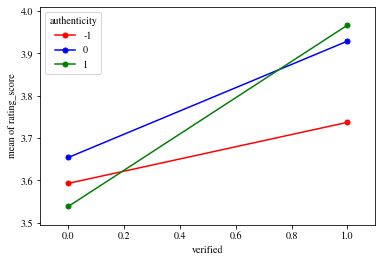

In [13]:
fig = interaction_plot(singleUser.verified, singleUser.authenticity, singleUser.rating_score,
             colors=['red','blue','green'], ms=10)

In [37]:
# Post hoc test: turkey test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
singleUser['combination'] = singleUser['authenticity'].astype(str) + '/' + singleUser['verified'].astype(str)
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=singleUser['rating_score'], groups=singleUser['combination'], alpha=0.05)

# coerce the tukeyhsd table to a DataFrame
tukey_data = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])
print(tukey_data)
group1_comp =tukey_data.loc[tukey_data.reject == True].groupby('group1').reject.count()
group2_comp = tukey_data.loc[tukey_data.reject == True].groupby('group2').reject.count()
tukey_data = pd.concat([group1_comp, group2_comp], axis=1)
tukey_data = tukey_data.fillna(0)
tukey_data.columns = ['reject1', 'reject2']
tukey_data['total_sum'] = tukey_data.reject1 + tukey_data.reject2

# just show the top 20 results
tukey_data.sort_values('total_sum',ascending=False).head(20)

   group1 group2  meandiff   p-adj   lower   upper  reject
0    -1/0   -1/1    0.1438  0.0660 -0.0052  0.2929   False
1    -1/0    0/0    0.0611  0.8327 -0.0880  0.2102   False
2    -1/0    0/1    0.3352  0.0010  0.1861  0.4842    True
3    -1/0    1/0   -0.0543  0.9000 -0.2034  0.0947   False
4    -1/0    1/1    0.3728  0.0010  0.2238  0.5219    True
5    -1/1    0/0   -0.0827  0.5940 -0.2318  0.0663   False
6    -1/1    0/1    0.1914  0.0035  0.0423  0.3404    True
7    -1/1    1/0   -0.1981  0.0022 -0.3472 -0.0491    True
8    -1/1    1/1    0.2290  0.0010  0.0799  0.3781    True
9     0/0    0/1    0.2741  0.0010  0.1250  0.4231    True
10    0/0    1/0   -0.1154  0.2334 -0.2645  0.0336   False
11    0/0    1/1    0.3117  0.0010  0.1627  0.4608    True
12    0/1    1/0   -0.3895  0.0010 -0.5386 -0.2404    True
13    0/1    1/1    0.0377  0.9000 -0.1114  0.1867   False
14    1/0    1/1    0.4272  0.0010  0.2781  0.5762    True


,reject1,reject2,total_sum
0/1,1.0,3.0,4.0
1/1,0.0,4.0,4.0
-1/1,3.0,0.0,3.0
1/0,1.0,2.0,3.0
-1/0,2.0,0.0,2.0
0/0,2.0,0.0,2.0


In [34]:
# Simple effect


group2
0/1    3
1/0    2
1/1    4
Name: reject, dtype: int64

In [25]:
singleUser

,userId,authenticity,verified,rating_score,combination
0,1,-1,0,3.3,-1/0
1,1,-1,1,3.7,-1/1
2,1,0,0,3.6,0/0
3,1,0,1,4.0,0/1
4,1,1,0,3.3,1/0
...,...,...,...,...,...
967,862,-1,1,3.5,-1/1
968,862,0,0,3.9,0/0
969,862,0,1,4.1,0/1
970,862,1,0,3.8,1/0
